In [1]:
from easy21 import *
import numpy as np

- Apply Monte-Carlo control to Easy21. 
- [x] Initialise the value function to zero. 
- [x] Use a time-varying scalar step-size of αt = 1/N(st,at) 
- [x] and an ε-greedy exploration strategy with εt = N0/(N0 + N(st)), 
- [x] where N0 = 100 is a constant, 
- [x] N(s) is the number of times that state s has been visited, 
- [x] and N(s,a) is the number of times that action a has been selected from state s. 
- [x] Feel free to choose an alternative value for N0, if it helps producing better results. 
- [x] Plot the optimal value function V ∗ (s) = maxa Q∗ (s, a) using similar axes to the following figure taken from Sutton and Barto’s Blackjack example.

In [2]:
class MC_Agent:
    def __init__(self, environment, n0):
        self.n0 = float(n0)
        self.env = environment
        
        # N(s) is the number of times that state s has been visited
        # N(s,a) is the number of times that action a has been selected from state s.
        self.N = np.zeros((self.env.dealer_values_count,
                           self.env.player_values_count, 
                           self.env.actions_count))
        
        self.Q = np.zeros((self.env.dealer_values_count,
                           self.env.player_values_count, 
                           self.env.actions_count))
        # self.E = np.zeros((self.env.dealer_values_count,
        #                    self.env.player_values_count, 
        #                    self.env.actions_count))

        # Initialise the value function to zero. 
        self.V = np.zeros((self.env.dealer_values_count, self.env.player_values_count))
        
        self.count_wins = 0
        self.iterations = 0

#     def get_action(self, s):
#         a = Actions.hit
#         return a
    
        # get optimal action, with epsilon exploration (epsilon dependent on number of visits to the state)
    # ε-greedy exploration strategy with εt = N0/(N0 + N(st)), 
    def get_action(self, state):
        dealer_idx = state.dealer-1
        player_idx = state.player-1
        n_visits = sum(self.N[dealer_idx, player_idx, :])

        # epsilon = N0/(N0 + N(st)
        curr_epsilon = self.n0 / (self.n0 + n_visits)

        # epsilon greedy policy
        if random.random() < curr_epsilon:
            return Actions.hit if random.random()<0.5 else Actions.stick
        else:
            return Actions.to_action(np.argmax(self.Q[dealer_idx, player_idx, :]))

    def train(self, iterations):        
        
        # Loop episodes
        for episode in xrange(iterations):
            episode_pairs = []
            
            # get initial state for current episode
            s = self.env.get_start_state()
            
            # Execute until game ends
            while not s.term:
                
                # get action with epsilon greedy policy
                a = self.get_action(s)
                
                # store action state pairs
                episode_pairs.append((s, a))
                
                # update visits
                # N(s) is the number of times that state s has been visited
                # N(s,a) is the number of times that action a has been selected from state s. 
                self.N[s.dealer-1, s.player-1, Actions.as_int(a)] += 1
                
                # execute action
                s,r = self.env.step(s, a)

            #if episode%10000==0: print "Episode: %d, Reward: %d" %(episode, my_state.rew)
            self.count_wins = self.count_wins+1 if r==1 else self.count_wins

            # Update Action value function accordingly
            for curr_s, curr_a in episode_pairs:
                # print s.dealer, s.player, s.r, a
                dealer_idx = curr_s.dealer-1
                player_idx = curr_s.player-1
                action_idx = Actions.as_int(curr_a)
                
                # Use a time-varying scalar step-size of αt = 1/N(st,at) 
                step = 1.0 / sum(self.N[dealer_idx, player_idx, :])
                error = r - self.Q[dealer_idx, player_idx, action_idx]
                self.Q[dealer_idx, player_idx, action_idx] += step * error

        self.iterations += iterations
        print float(self.count_wins)/self.iterations*100

        # Derive value function
        for d in xrange(self.env.dealer_values_count):
            for p in xrange(self.env.player_values_count):
                self.V[d,p] = max(self.Q[d, p, :])
                
    def plot_frame(self, ax):
        def get_stat_val(x, y):
            return self.V[x, y]

        X = np.arange(0, self.env.dealer_values_count, 1)
        Y = np.arange(0, self.env.player_values_count, 1)
        X, Y = np.meshgrid(X, Y)
        Z = get_stat_val(X, Y)
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        return surf

# TODO 
#  add missing values
#  make train so it can be ran multiple sets of itteractions
#   (and figure out when to compute the value function and to make sure its done from start of file

In [3]:
# where N0 = 100 is a constant, 
N0 = 100

In [4]:
N0 = 100
agent = MC_Agent(Environment(), N0)
for i in xrange (10):
    agent.train(50000)

50.018
50.508
50.9506666667
51.1525
51.3256
51.4363333333
51.5508571429
51.62825
51.6582222222
51.7446


In [6]:
# Feel free to choose an alternative value for N0, if it helps producing better results.

In [7]:
N0 = 300
agent = MC_Agent(Environment(), N0)
for i in xrange (10):
    agent.train(50000)

48.242
49.48
49.9646666667
50.3435
50.5864
50.7013333333
50.8582857143
50.964
51.0493333333
51.1312


In [8]:
N0 = 30
agent = MC_Agent(Environment(), N0)
for i in xrange (10):
    agent.train(50000)

49.776
50.677
51.0226666667
51.1155
51.3028
51.3463333333
51.3622857143
51.4335
51.4482222222
51.4692


## Plot

In [50]:
N0 = 100
agent = MC_Agent(Environment(), N0)

In [51]:
def animate(frame):
    i = agent.iterations
    step_size = i
    step_size = max(1, step_size)
    step_size = min(step_size, 2 ** 16)
    # agent.MC_run(100000)
    # agent.MC_run(step_size)
    agent.train(step_size)

    ax.clear()
    surf =  agent.plot_frame(ax)
    plt.title('MC score:%s frame:%s step_size:%s ' % (float(agent.count_wins)/agent.iterations*100, frame, step_size) )
    # plt.draw()
    fig.canvas.draw()
    print "done ", frame, step_size, i
    return surf, "hello", "snow"

100.0
done  0 1 0
50.0
done  0 1 1
50.0
done  1 2 2
50.0
done  2 4 4
56.25
done  3 8 8
53.125
done  4 16 16
45.3125
done  5 32 32
48.4375
done  6 64 64
48.4375
done  7 128 128
45.1171875
done  8 256 256
45.60546875
done  9 512 512
45.361328125
done  10 1024 1024
46.2646484375
done  11 2048 2048
46.9970703125
done  12 4096 4096
47.8271484375
done  13 8192 8192
48.8891601562
done  14 16384 16384
49.8748779297
done  15 32768 32768
50.4989624023
done  16 65536 65536
50.8717854818
done  17 65536 131072
51.0749816895
done  18 65536 196608
51.2048339844
done  19 65536 262144
51.3186136882
done  20 65536 327680
51.394871303
done  21 65536 393216
51.4612197876
done  22 65536 458752
51.5019734701
done  23 65536 524288
51.5293884277
done  24 65536 589824
51.5848333185
done  25 65536 655360
51.6105651855
done  26 65536 720896
51.6402024489
done  27 65536 786432
51.6420636858
done  28 65536 851968
51.6672770182
done  29 65536 917504
51.6765594482
done  30 65536 983040
51.6923792222
done  31 65536 1

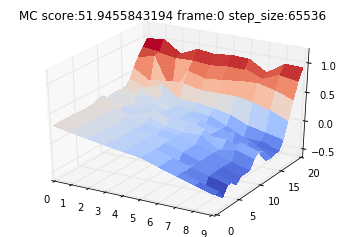

In [52]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# ani = animation.FuncAnimation(fig, animate, 10, repeat=False)
ani = animation.FuncAnimation(fig, animate, 32, repeat=False)
# ani = animation.FuncAnimation(fig, animate, 100, repeat=False)

# note: requires gif writer; swap with plt.show()
ani.save('MC_Agent.gif', writer='imagemagick', fps=3)
# plt.show()

In [53]:
from IPython.display import Image
# Image(filename='animation.gif') 
Image(url="MC_Agent.gif")

In [49]:
agent.env

<easy21.Environment instance at 0x10967db00>